# Testing out DNA-BERT2 with Real data: May 12, 2025
Research Objectives:
* I have enhancers that were upregulated in response to transcription factor p53 being activated. Many of these calls are enriched in p53 motifs.
* I want to see if I can capture the p53 motif AND the other sequence factors determining if a sequence is being upregulated in response to p53 being activated.

Learning Objectives
* Dealing with imbalanced classes to call (e.g. way more 0s than 1s)
* Assessing a model beyond simple accuracy

## 1. Installations

In [2]:
# =============================
#  1. Install the necessary libraries
# =============================
# !pip install transformers datasets torch scikit-learn
# !pip install shap
# !pip install matplotlib

# =============================
#  2. Import Libraries
# =============================
import matplotlib
import torch
import pickle
import pandas as pd
import random
import shap
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


/Users/hopekirby/.pyenv/versions/3.8.20/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Reading in the Dataset
1. Read in the full list of enhancers and only consider those that are not at Gene transcription start sites
2. LE_res is a dataframe with columns corresponding to different celltypes and ways to capture the enhancers changing transcription in response to p53 activation
3. I can then get the list of enhancers that are class 1 (On - changing transcription with p53) or 0 (Off - no response to p53 actiation)
4. Balance on and off calls
5. Get the sequences of these regions (bed file to fasta file)

In [3]:
# Read in the full list of enhancers
ranked_df = pd.read_csv("~/Desktop/TF_Enh_Linking/Bench_DE/p53/bin/p53_AndryJones7_MUMERGE_10kbwin_tfit,dreg_03-27-24.sorted.bed", 
                       sep="\t", header=None)
ranked_df.iloc[0:2,]

ranked_df['mu'] = (ranked_df.iloc[:, 1].astype(int) + ranked_df.iloc[:, 2].astype(int)) // 2
ranked_df['Name'] = ranked_df.iloc[:, 0].astype(str) + ":" + ranked_df['mu'].astype(str)
ranked_df.iloc[0:2,]

# Only consider the regions NOT at gene transcription start sites
tss_df = pd.read_csv("/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/data/counts/tss_bid_AndryJones7_50bpwin_03-28-24.txt", sep='\t')
# Get unique BidID values, dropping any NA
tss_df['mu'] = (tss_df.iloc[:, 1].astype(int) + tss_df.iloc[:, 2].astype(int)) // 2
tss_df['Name'] = tss_df.iloc[:, 0].astype(str) + ":" + tss_df['mu'].astype(str)
tss = set(tss_df['Name'].dropna())
# Compute the difference
all_enhancers = set(ranked_df['Name'].dropna()) - tss
print(len(all_enhancers))

153291


In [25]:
# Read in enhancers changing transcription with p53
LE_res = pd.read_csv("/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/bin/LE_P53_Results.csv")
LE_res.iloc[0:2,]


,MCF7_p05,MCF7_mu500_PE,SJSA_p05,SJSA_mu500_PE,HCT116_p05,HCT116_mu500_PE
0,chr1:115839386,chr1:115839386,chr12:68787452,chr8:142815892,chr8:142815892,chr8:142815892
1,chr19:55601389,chr19:55601389,chr8:142815892,chr11:5690483,chr1:27343089,chr6:36667358


In [26]:
# Get the list of Off and On

MCF7_on = set(LE_res.MCF7_mu500_PE.dropna())
MCF7_off = all_enhancers - MCF7_on

SJSA_on = set(LE_res.SJSA_mu500_PE.dropna())
SJSA_off = all_enhancers - SJSA_on

HCT116_on = set(LE_res.HCT116_mu500_PE.dropna())
HCT116_off = all_enhancers - HCT116_on

print(len(MCF7_on), len(MCF7_off), 
      len(SJSA_on), len(SJSA_off), 
      len(HCT116_on), len(HCT116_off))

209 153082 320 152971 511 152780


### A. Trying to Balance On vs Off calls
I have 150,000+ Off regions and 200-511 On regions. That is super unbalanced. Models can get confused since they might perform really well on the off regions but horribly on the on regions. In a balanced dataset, this would clearly show up in the error, but if most of the dataset is off then the model is performing well on most of the dataset and so the accuracy would actually be really good still.
Therefore, I am going to take a random sample of about 2,000 of the off regions.

In [29]:
## Rath
MCF7_off_sample = random.sample(MCF7_off, 2000)
len(MCF7_off_sample)
SJSA_off_sample = random.sample(SJSA_off, 2000)
len(SJSA_off_sample)
HCT116_off_sample = random.sample(HCT116_off, 2000)
len(HCT116_off_sample)

2000

### B. Get FASTA sequences (e.g. ATGC) for the sequences of interest
* I am using 500bp regions since I expect Transcription Factor motifs to likely be within this range and also not have to use too much computational power
* Get_bed_regions gets the 500bp regions of the on and off regions to a bed file. I can then convert these bedfiles to fasta files (with sequences) by using ```bedtools getfasta```
* Then get_on_off_df function reads in the fasta files, only getting the sequences, and gives on regions a label of 1 and off regions a label of 0 in a dataframe.

In [36]:
# save the regions as bed files with 500bp regions
#MCF7_on
def get_bed_regions(on, off, on_name, off_name):
    # Example inputs: MCF7_on and MCF7_off_sample should be sets/lists of strings like "chr1:123456"
    on_df = pd.DataFrame([s.split(":") for s in MCF7_on], columns=['chrom', 'pos'])
    off_df = pd.DataFrame([s.split(":") for s in MCF7_off_sample], columns=['chrom', 'pos'])
    
    # Convert position to integer
    on_df['pos'] = on_df['pos'].astype(int)
    off_df['pos'] = off_df['pos'].astype(int)
    
    on_df = pd.DataFrame({
            'chrom': on_df['chrom'],
            'start': on_df['pos'] - 250,
            'stop': on_df['pos'] + 250
        })
    
    off_df = pd.DataFrame({
            'chrom': off_df['chrom'],
            'start': off_df['pos'] - 250,
            'stop': off_df['pos'] + 250
        })
    on_df.to_csv(on_name, sep="\t", index=False, header=False)
    off_df.to_csv(off_name, sep="\t", index=False, header=False)

In [37]:
get_bed_regions(MCF7_on, MCF7_off, "./MCF7_on.bed", "./MCF7_off.bed")
get_bed_regions(SJSA_on, SJSA_off, "./SJSA_on.bed", "./SJSA_off.bed")
get_bed_regions(HCT116_on, HCT116_off, "./HCT116_on.bed", "./HCT116_off.bed")

In [2]:
## Make dfs for on and off
def get_on_off_df(celltype):
    on_file = "".join([celltype, "_on.fa"])
    on = pd.read_csv(on_file, sep="\t", header=None)
    on = on[~on.iloc[:, 0].str.contains(">", na=False)]
    on["Status"] = 1

    off_file = "".join([celltype, "_off.fa"])
    off = pd.read_csv(off_file, sep="\t", header=None)
    off = off[~off.iloc[:, 0].str.contains(">", na=False)]
    off["Status"] = 0

    full_df = pd.concat([on, off])
    full_df.columns = ["sequence", "label"]
    return full_df

MCF7_df = get_on_off_df("MCF7")
SJSA_df = get_on_off_df("SJSA")
HCT116_df = get_on_off_df("HCT116")

## 3. Fine Tuning with the DNABERT-2 model
THis is essentially identical to the toy dataset but we are using data from one of the celltypes instead.
Instead of using all 2000 off regions, I only consider the first 1000 regions (all 43 on regions and 957 off regions).

In [9]:
MCF7_df = MCF7_df.iloc[0:1000,]
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(MCF7_df['sequence'], 
                                                                    MCF7_df['label'], test_size=0.25)

# Convert into Dataset format
train_dataset = Dataset.from_dict({"sequence": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"sequence": val_texts.tolist(), "label": val_labels.tolist()})

# =============================
#  4. Tokenize the datasets
# =============================
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# pad shorter sequences to the longest one in the batch. Truncate shorter than 512 tokens
def tokenize_function(examples):
    return tokenizer(examples["sequence"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# =============================
#  5. Define Training Arguments
# =============================
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# =============================
# 🚀 6. Define Trainer
# =============================
model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True, num_labels=2)

#model = AutoModelForSequenceClassification.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, num_labels=2)


Map: 100%|████████████████████████████████| 250/250 [00:00<00:00, 3330.04 examples/s]
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were no

In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)
def compute_metrics(eval_pred):
    logits, labels = eval_pred  # This returns a tuple (logits, labels)
    
    # Extract the logits tensor from the tuple, if needed
    logits = logits[0]  # In case logits is a tuple, take the first element
    
    # Convert logits to a PyTorch tensor (if it's not already)
    logits = torch.tensor(logits)
    
    # If logits are 3D, take argmax along the second axis (sequence length axis)
    logits = logits.argmax(dim=-1)  # Shape will now be (batch_size,)
    
    # Flatten the logits and labels to compare them
    preds = logits.flatten()
    labels = labels.flatten()

    # Calculate accuracy
    return {"accuracy": accuracy_score(labels, preds)}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# =============================
#  7. Fine-tune the Model
# =============================
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.652600,0.665355,0.796000
2,0.681600,0.671504,0.796000
3,0.642800,0.631771,0.796000


TrainOutput(global_step=1125, training_loss=0.6590270453559027, metrics={'train_runtime': 5693.9576, 'train_samples_per_second': 0.395, 'train_steps_per_second': 0.198, 'total_flos': 787434518016000.0, 'train_loss': 0.6590270453559027, 'epoch': 3.0})

In [11]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

### Interpretation
* The training loss and validation loss are very similar to one another and the accuracy and loss don't seem to be significantly changing. This is likely because the model hasn't learned anything significant yet. Therefore, I should probably have used more epochs for training.
* When I ran with 2000 off regions instead of just 957 I got a higher accuracy (about 0.9) but this might just be because it is doing well on the off regions rather than the on.

## 4. GET SHAP Values for the model
Like last time we can get the SHAP values of the tokens to see which tokens are the most important in determining whether a call is on or off.

We expect the P53 motif (CATG being the cleanest component) to be an important token given we are trying to predict P53 responsive enhancers. Therefore, let's look at the SHAP values based on interogating regions we KNOW have the motif.
* get_fimo_results is finding the regions that have a P53 motif within 250 bp of the center (therefore within the region BERT2 was studying).
* get_motif_sequences is getting the sequences of the regions with a motif
* predict_fn is like last time where it just summarizes the way our model is run to predict something so that SHAP can use it 

In [12]:
# choose some sequences that have the P53 motif in it (what we expect to be causing the difference
# Load FIMO results
def get_fimo_results(fimo_file):
    # Load file assuming it's tab-delimited
    fimo_p53 = pd.read_csv(fimo_file, sep='\t')

    # Split sequence_name into chromosome and range
    split1 = fimo_p53['sequence_name'].str.split(":", expand=True)
    chrom = split1[0]
    positions = split1[1].str.split("-", expand=True).astype(int)

    # Compute mu (midpoint of region)
    mu = ((positions[0] + positions[1]) / 2).astype(int)
    fimo_p53['mu'] = mu

    # Compute motif position relative to region start
    fimo_p53['motif'] = fimo_p53['start'] + positions[1] - 10000

    # Calculate MUDIFF as absolute difference
    fimo_p53['MUDIFF'] = (fimo_p53['motif'] - fimo_p53['mu']).abs().astype(int)

    # Create unique region name
    fimo_p53['name'] = chrom + ":" + mu.astype(str)

    # Optional: Print summary and motif < 250bp
    motif = fimo_p53[fimo_p53['MUDIFF'] < 250]
    print("\nNumber regions <300 MUDIFF:", motif['name'].nunique())

    return motif
fimo_file="/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/data/overlaps/P53.H12CORE.0.P.B_p1e6.fimo.bed"
motif_250 = get_fimo_results(fimo_file)



Number regions <300 MUDIFF: 1626


In [13]:
# choose a subset of sequences
def get_motif_sequences(on_bed_file, sequence_df):
    on_bed = pd.read_csv(on_bed_file, sep="\t", header=None)
    mu = ((on_bed[1].astype(int) + on_bed[2].astype(int)) // 2)
    # Slice and copy sequence_df to avoid SettingWithCopyWarning
    sequence_on_df = sequence_df.iloc[0:on_bed.shape[0], :].copy()
    # Create 'name' column using .loc to avoid warnings
    sequence_on_df.loc[:, 'name'] = on_bed[0] + ":" + mu.astype(str)
    # Ensure motif_250 is a list/Series of names
    motif_names = motif_250['name'].tolist() if hasattr(motif_250, 'name') else list(motif_250)
    # Filter by motif presence
    motif_sequences = sequence_on_df[sequence_on_df['name'].isin(motif_names)]
    print("Number on sequences with motif within 250bp:", motif_sequences.shape[0])
    return(motif_sequences.sequence.tolist())

MCF7_moton_seq = get_motif_sequences("./MCF7_on.bed", MCF7_df)
#MCF7_moton_seq



Number on sequences with motif within 250bp: 43


In [14]:
# Create a function to predict the model's outputs
def predict_fn(input_ids):
    input_ids = torch.tensor(input_ids)  # Ensure input_ids is a PyTorch tensor
    # no_grad() means that gradients aren't tracked (unnecessary since we're not training the model)
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits
        # If logits is a tuple, take the first element
        logits = logits  # Shape should be (batch_size, num_classes)
        print(logits.shape)
    
    # Apply softmax to get probabilities for each class
    probabilities = torch.nn.Softmax(dim=-1)(logits).numpy()  # Shape will be (batch_size, num_classes)
    
    return probabilities  # Return probabilities for each class


# Tokenize a sample input (to be used in SHAP)
tokenized_samples = tokenizer(MCF7_moton_seq[1:4], padding=True, truncation=True, max_length=512, return_tensors="pt")

# Explain predictions using SHAP
explainer = shap.KernelExplainer(predict_fn, tokenized_samples['input_ids'].numpy())
shap_values = explainer.shap_values(tokenized_samples['input_ids'].numpy(), nsamples=1000)



torch.Size([3, 2])


  0%|                                                          | 0/3 [00:00<?, ?it/s]

torch.Size([1, 2])
torch.Size([3000, 2])


 33%|███████████████▎                              | 1/3 [30:28<1:00:56, 1828.37s/it]

torch.Size([1, 2])
torch.Size([3000, 2])


 67%|████████████████████████████████                | 2/3 [58:13<28:52, 1732.14s/it]

torch.Size([1, 2])
torch.Size([3000, 2])


100%|██████████████████████████████████████████████| 3/3 [1:27:12<00:00, 1744.29s/it]


In [40]:
# see how well the model works on the regions of interest

with torch.no_grad():
    outputs = model(**tokenized_samples)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()


# Print results
for pred in predictions:
    print(f"Predicted class: {pred}\n")

Predicted class: 0

Predicted class: 0

Predicted class: 0



In [15]:
# Save the shap_values object to a file
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

# Also save the input data if you want (optional but helpful)
with open("tokenized_input_ids.pkl", "wb") as f:
    pickle.dump(tokenized_samples['input_ids'].numpy(), f)

In [28]:
## Assigning sequence back to tokens

tokens = tokenizer.convert_ids_to_tokens(tokenized_samples['input_ids'].numpy()[0].tolist())

print(tokens)  # You should now see actual tokens like 'ATG', 'GCGC', etc.

# Create a list of token positions
token_positions = [f"Position {idx}: {token}" for idx, token in enumerate(tokens)]
print(token_positions)

['[CLS]', 'GAATCA', 'GGTG', 'CCCTG', 'TCCTGA', 'CATG', 'TCCCA', 'GAGA', 'CACA', 'GCTT', 'GAGTG', 'GGAAA', 'TGAGG', 'GAGG', 'TGAGTCA', 'GG', 'GCTGGG', 'TGTT', 'GGGG', 'GCAA', 'GAGAAA', 'GGGG', 'CAGGAGG', 'TCTG', 'TCCCATT', 'TCTGA', 'GGACACA', 'GGGA', 'CCAGG', 'GCTG', 'GCAGGAA', 'CCA', 'GGAAA', 'GGGTG', 'GGTT', 'CCCCA', 'GGGTG', 'GGAATT', 'GCACAGG', 'GTTGG', 'CTCA', 'GTGGG', 'TCTTTG', 'GCCCAA', 'GGCC', 'TCCA', 'CCTCTCC', 'TGGG', 'TTACAGG', 'CTCA', 'GGCAGG', 'CCCC', 'GGAAA', 'GCAGGA', 'CTGCAGG', 'CGG', 'CATA', 'GGGG', 'CGGA', 'TGGG', 'GCGAGG', 'CTGGAA', 'GGCA', 'TCTT', 'GC', 'CACATT', 'GTCTAGG', 'GAAGAA', 'CCAATG', 'CTGA', 'GGCC', 'TGA', 'GAATA', 'GTGA', 'GATA', 'GCC', 'GCGC', 'GATG', 'TCACCTG', 'CACAA', 'TGCA', 'CTAA', 'GATCAA', 'CAGGA', 'GACCTG', 'GCAGG', 'GGAGGAGG', 'GAGGGCA', 'TCCTG', 'TCTCTCCA', 'GCCCC', 'CTCC', 'CC', 'GCCTCC', 'TA', 'TGAGG', 'CCTG', 'CCCA', 'CTC', 'TGTGTG', 'CTGCC', 'CGCTG', 'CAGC', 'GG', '[SEP]']
['Position 0: [CLS]', 'Position 1: GAATCA', 'Position 2: GGTG', 'Posi

In [35]:
len(token_positions)
len(shap_values)

2

In [31]:
shap_dict = dict(zip(token_positions, shap_values[0]))
shap_dict.keys()

dict_keys(['Position 0: [CLS]', 'Position 1: GAATCA', 'Position 2: GGTG'])

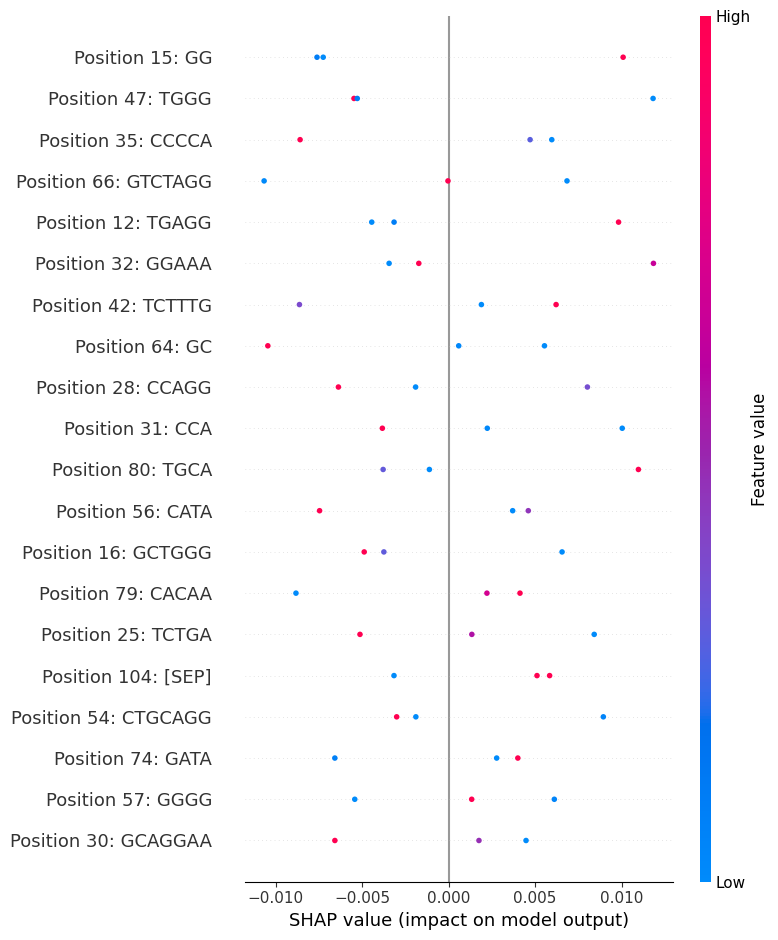

In [29]:
shap.summary_plot(shap_values[0], 
                  tokenized_samples['input_ids'].numpy(), 
                  feature_names=token_positions)

#### Interpretation: 
The P53 motif is no where really to be seen as having a significant SHAP value and no clear token is having a clean and obvious impact (check out the Testing_BERT_Toy.ipynb to shee a clean result). Despite our model having 80% accuracy, it clearly is not doing a good job of capturing what we expect. Therefore, let's see how well the model is doing at predicting the regions we know should be called on simply with the presence of a P53 motif.

### Which of the expected TPs are called correctly for SHAP evaluation

In [41]:
tokenized_samples = tokenizer(MCF7_moton_seq, padding=True, truncation=True, max_length=512, return_tensors="pt")

with torch.no_grad():
    outputs = model(**tokenized_samples)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()


# Print results
for pred in predictions:
    print(f"Predicted class: {pred}\n")


Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0

Predicted class: 0



#### Interpretation
None of the regions are called on. This means that are model is NOT effective. The 80% accuracy is likely because it is simply predicting the off regions successfully off. If the model assumed everything was off, it would still be about 957/1000 = 96% accurate despite that being a ridiculous solution. Therefore, let's see if we can improve training and evaluation of the model with a super imablanced class size.

## 5. Better addressing imbalanced class size
Possible Solutions:
1. **Create more balanced classes:** Originally used about 950 negative regions and 43 positive regions. Now I can try about 450 negative regions and 43 positive regions. We don't want to remove most negative regions since there might be some important things the model can learn still.
2. **Not using metrics that are biased by class sizes**
    * A model's parameters are changed after each epoch/batch to try to minimize the *loss function.* The trained models are then evaluated on a validation dataset the model has never seen before. The best model among those is chosen based on a decided metric (NOT the loss function) like accuracy.
    * Problems with biased class sizes:
      * The loss function is looking at error and doesn't care abotu class size. Therefore, if it calls nothing changing at all (which is stupid), it can still do well if like 90% of the dataset isn't changing.
      * Accuracy has the same problem as above. We can get a high accuracy for more than 90% of the dataset by just saying nothing changes
    * Solutions
        * We can edit the loss function so that the model will care more about getting a specific class correct. We do this with a *Weighted loss function* where the class we care more about (are 1s) are weighted more strongly in the loss function as determining how well the model is doing.
        * We can use a metric for choosing the final best model that is not as reliant on class balance. F1 scores weight false positives/negatives more than accuracy and tends to be better for imbalanced classes. Weighted F1 scores (F-beta) that weight recall over precision might be even better.

### A. Using more balanced class sizes

In [46]:
MCF7_df = MCF7_df.iloc[0:500,]
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(MCF7_df['sequence'], 
                                                                    MCF7_df['label'], test_size=0.25)

# Convert into Dataset format
train_dataset = Dataset.from_dict({"sequence": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"sequence": val_texts.tolist(), "label": val_labels.tolist()})

# =============================
#  4. Tokenize the datasets
# =============================
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# pad shorter sequences to the longest one in the batch. Truncate shorter than 512 tokens
def tokenize_function(examples):
    return tokenizer(examples["sequence"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Map: 100%|████████████████████████████████| 125/125 [00:00<00:00, 2572.12 examples/s]


### B. Using f1 score to evaluate models rather than accuracy to capture recall better

In [50]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

In [48]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits[0])  # assuming logits is a tuple
    preds = logits.argmax(dim=-1)
    labels = labels.flatten()
    preds = preds.flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

### C. Have the loss function (used to train model) weight calling the true positives correctly more
* The loss function is what the model is trying to minimize during training.
* Cross Entropy is commonly used for classification problems since it considers probability distributions. Therefore we will add our weights to this loss function.

In [47]:
# Define your class weights (neg=0, pos=1)
class_weights = torch.tensor([1.0, 1000 / 43]).to(model.device)

# Function to calculate the weighted loss
def compute_weighted_loss(outputs, labels):
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    return loss_fn(outputs, labels)

# Override compute_loss in a custom trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = compute_weighted_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Defining the trainer as the Weighted Trainer class above rather than default Trainer class from Transformers
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [51]:
# =============================
#  7. Fine-tune the Model
# =============================
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.450100,0.844966,0.640000,0.540230,0.903846,0.676259
2,0.399700,0.912263,0.688000,0.586667,0.846154,0.692913
3,0.332800,0.912263,0.688000,0.586667,0.846154,0.692913


TrainOutput(global_step=375, training_loss=0.39418313598632815, metrics={'train_runtime': 3613.1796, 'train_samples_per_second': 0.311, 'train_steps_per_second': 0.104, 'total_flos': 393717259008000.0, 'train_loss': 0.39418313598632815, 'epoch': 3.0})

In [52]:
tokenized_samples = tokenizer(MCF7_moton_seq, padding=True, truncation=True, max_length=512, return_tensors="pt")

with torch.no_grad():
    outputs = model(**tokenized_samples)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).tolist()


# Print results
for pred in predictions:
    print(f"Predicted class: {pred}\n")

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 0

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 0

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 1

Predicted class: 0

Predicted class: 1



#### Interpretation
Despite the accuracy being lower, we are now actually predicting our clearly on regions as being on. Therefore, our changes helped. Having more epochs would likely allow a cleaner model. I could also include the true calls from all the cell types to allow a more balanced and larger dataset on which the model can train.